In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from functools import partial

# 指定支持中文的字体，例如SimHei或者Microsoft YaHei
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题

In [2]:
# 读取Excel文件
df = pd.read_excel('A1.xlsx', usecols=['销量（箱）', '金额（元）'])
# 去掉无数值的行
df.dropna(inplace=True)
# 将数据转换为NumPy数组
data_array = df.values
index = pd.date_range(start='2011-01', periods=data_array.shape[0], freq='M')
df = pd.DataFrame(data_array, index=index, columns=['销量', '金额'])

In [71]:
series = df.loc['2014-02':, '销量']
data = series.values

# 创建 MinMaxScaler 的实例
scaler = RobustScaler()
# 使用 fit_transform 方法来拟合数据并转换它
normalized_data = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)

normalized_series = pd.Series(normalized_data, index=series.index)

In [4]:
# 将Series转换为DataFrame，并设置日期为索引  
sales_df = normalized_series.reset_index()  
sales_df.columns = ['date', 'sales']  
sales_df['date'] = pd.to_datetime(sales_df['date'])
# 确保数据按日期排序  
sales_df = sales_df.sort_values('date')

In [5]:
# 创建特征集和目标集
future_length = 12
# 使用前 feature_length 个月的销量作为特征，预测下一个月的销量
features = []
targets = []

sales_df['year'] = (sales_df['date'].dt.year - 2014) / 5.
sales_df['month'] = (sales_df['date'].dt.month - 1) / 6.

for i in range(future_length, len(sales_df)):
    # 获取销量特征
    sales_features = sales_df['sales'].iloc[i-future_length:i].tolist()

    # 获取年份和月份特征
    year_features = sales_df['year'].iloc[i-future_length:i].tolist()
    month_features = sales_df['month'].iloc[i-future_length:i].tolist()

    # 将年份和月份添加到特征向量中
    feature_vector = [sales_features, year_features, month_features]

    # 添加到特征集中
    features.append(feature_vector)

    # 添加目标销量
    targets.append(sales_df['sales'].iloc[i])

# 将特征和目标转换为numpy数组
features = torch.tensor(features, dtype=torch.float32)
features = features.permute(0, 2, 1)
targets = torch.tensor(targets, dtype=torch.float32)

In [6]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    features, targets, test_size=12/features.shape[0])
X_train, X_test, y_train, y_test = map(
    lambda x: x.cuda(), (X_train, X_test, y_train, y_test))

In [7]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=12)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=12)

In [8]:
# 4.1 LSTM 模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 使用最后一个时间步的输出
        return out

    def init_weights(self):
        # 遍历 LSTM 层的参数，对参数进行初始化
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param, mean=0, std=0.1)  # 使用正态分布初始化权重
            elif 'bias' in name:
                nn.init.constant_(param, 0)  # 将偏置项初始化为零
                
model_parameters = {
    "input_size": 3, "hidden_size": 32, "num_layers": 1, "output_size": 1
}

In [2]:
# 5.1 初始化模型、损失函数和优化器
model = LSTMModel(**model_parameters)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5)

# 初始化最佳模型参数和最佳验证损失
best_model_params = model.state_dict()
best_val_loss = float('inf')

NameError: name 'LSTMModel' is not defined

In [10]:
model.cuda()
# 5.2 训练模型
num_epochs = 1500
train_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    train_loss = 0
    for batch_input, batch_target in train_dataloader:
        optimizer.zero_grad()
        output = model(batch_input)
        loss = criterion(output.squeeze(), batch_target)
        train_loss += loss
        loss.backward()
        optimizer.step()
    train_loss = train_loss/len(train_dataloader)
    train_loss_list.append(train_loss.item())

    scheduler.step(train_loss)

    if (epoch + 1) % 50 == 0:
        # 在验证集上计算损失并保存最佳模型
        with torch.no_grad():
            val_losses = []
            for val_batch_input, val_batch_target in test_dataloader:
                val_output = model(val_batch_input)
                val_loss = criterion(val_output.squeeze(), val_batch_target)
                val_losses.append(val_loss.item())
            avg_val_loss = np.mean(val_losses)
            val_loss_list.append(avg_val_loss)

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_params = model.state_dict()

        print(f'Epoch [{epoch+1}/{num_epochs}], Learn Rate: {scheduler.get_last_lr()[0]:.4e}, ' +
              f'Training Loss: {train_loss.item():.4f}, Validation Loss: {avg_val_loss:.4f}')

torch.save(best_model_params, './best_model_LSTM.pth',
           _use_new_zipfile_serialization=False)

Epoch [50/1500], Learn Rate: 1.0000e-03, Training Loss: 0.3496, Validation Loss: 0.5981
Epoch [100/1500], Learn Rate: 1.0000e-03, Training Loss: 0.1702, Validation Loss: 0.8048
Epoch [150/1500], Learn Rate: 1.0000e-03, Training Loss: 0.0802, Validation Loss: 0.4177
Epoch [200/1500], Learn Rate: 1.0000e-03, Training Loss: 0.0474, Validation Loss: 0.4478
Epoch [250/1500], Learn Rate: 5.0000e-04, Training Loss: 0.0391, Validation Loss: 0.4280
Epoch [300/1500], Learn Rate: 5.0000e-04, Training Loss: 0.0358, Validation Loss: 0.4196
Epoch [350/1500], Learn Rate: 5.0000e-04, Training Loss: 0.0328, Validation Loss: 0.3906
Epoch [400/1500], Learn Rate: 5.0000e-04, Training Loss: 0.0299, Validation Loss: 0.3608
Epoch [450/1500], Learn Rate: 5.0000e-04, Training Loss: 0.0269, Validation Loss: 0.3374
Epoch [500/1500], Learn Rate: 5.0000e-04, Training Loss: 0.0237, Validation Loss: 0.3241
Epoch [550/1500], Learn Rate: 5.0000e-04, Training Loss: 0.0205, Validation Loss: 0.3201
Epoch [600/1500], Lear

In [40]:
# 6.1 加载模型
model_lstm = LSTMModel(**model_parameters)
model_lstm.load_state_dict(torch.load('./best_model_LSTM.pth'))
model_lstm.eval()

LSTMModel(
  (lstm): LSTM(3, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

从2019年9月开始后续数据推理
tensor([[[-1.1208,  1.0000,  1.5000]]])
tensor([[[-0.4209,  1.0000,  1.6667]]])
tensor([[[0.0669, 1.0000, 1.8333]]])
tensor([[[2.7959, 1.2000, 0.0000]]])
tensor([[[-0.1484,  1.2000,  0.1667]]])
tensor([[[0.2291, 1.2000, 0.3333]]])
tensor([[[0.1019, 1.2000, 0.5000]]])
tensor([[[-0.0140,  1.2000,  0.6667]]])
tensor([[[0.5065, 1.2000, 0.8333]]])
tensor([[[0.9027, 1.2000, 1.0000]]])
tensor([[[0.0514, 1.2000, 1.1667]]])
tensor([[[-0.5166,  1.2000,  1.3333]]])
tensor([[[0.3018, 1.2000, 1.5000]]])
tensor([[[-0.2018,  1.2000,  1.6667]]])
tensor([[[0.1429, 1.2000, 1.8333]]])
tensor([[[1.0018, 1.4000, 0.0000]]])
tensor([[[2.4426, 1.4000, 0.1667]]])
tensor([[[1.1360, 1.4000, 0.3333]]])
tensor([[[0.4955, 1.4000, 0.5000]]])
tensor([[[0.5960, 1.4000, 0.6667]]])
tensor([[[0.8843, 1.4000, 0.8333]]])
tensor([[[0.9742, 1.4000, 1.0000]]])
tensor([[[0.0097, 1.4000, 1.1667]]])
tensor([[[0.2967, 1.4000, 1.3333]]])
MSE: 200.99
MAE: 10.97
R^2: 0.83
MAPE: 0.23


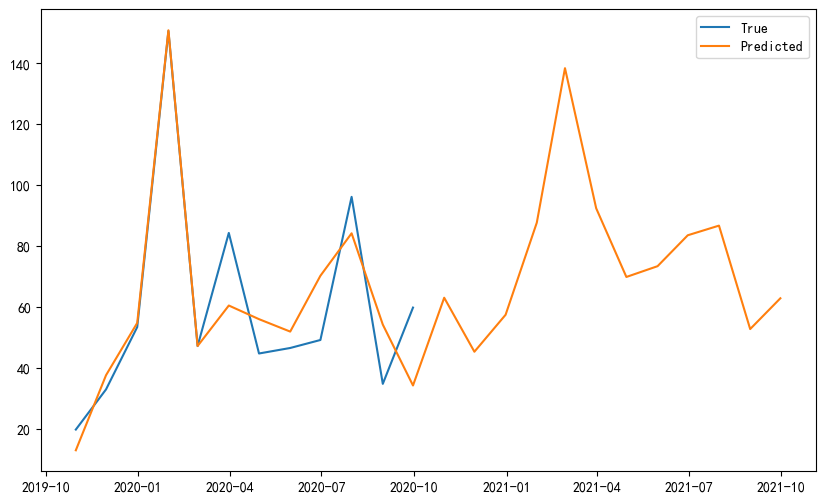

array([ 12.99242065,  37.62003523,  54.78497556, 150.81449369,
        47.20900777,  60.49335648,  56.01851647,  51.93767128,
        70.25557373,  84.19584081,  54.23905997,  34.25275456,
        63.05182379,  45.33006889,  57.45954583,  87.68399071,
       138.38277131,  92.4052589 ,  69.86647417,  73.40408421,
        83.5487293 ,  86.71180809,  52.77366129,  62.87126031])

In [76]:
import model_predict
import importlib
importlib.reload(model_predict)
model_predict.predict_to_future_lstm(model_lstm, series, 24, scaler)